# Прогнозирование оттока клиентов

**Контекст:** сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе данных.

**Проблема:** отток клиентов

**Задача:**
- построение модели прогнозирования оттока клиента
- сегментация клиентов

**Реализация алгоритмов**
- Логистическая регрессия
- Случайный лес
- Кластеризация

**Данные**

| Переменная                      | Описание                                                                                      |
|---------------------------------|-----------------------------------------------------------------------------------------------|
| gender                          | пол                                                                                           |
| Near_Location                   | проживание или работа в районе, где находится фитнес-центр                                     |
| Partner                         | сотрудник компании-партнёра клуба                                                             |
| Promo_friends                   | факт первоначальной записи в рамках акции «приведи друга»                                      |
| Phone                           | наличие контактного телефона                                                                  |
| Age                             | возраст                                                                                       |
| Lifetime                        | время с момента первого обращения в фитнес-центр (в месяцах)                                   |
| Contract_period                 | длительность текущего действующего абонемента (месяц, 6 месяцев, год)                         |
| Month_to_end_contract           | срок до окончания текущего действующего абонемента (в месяцах)                                |
| Group_visits                    | факт посещения групповых занятий                                                              |
| Avg_class_frequency_total       | средняя частота посещений в неделю за все время с начала действия абонемента                  |
| Avg_class_frequency_current_month | средняя частота посещений в неделю за предыдущий месяц                                       |
| Avg_additional_charges_total    | суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон |
| Churn                           | факт оттока в текущем месяце                                                                  |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.shape

(4000, 14)

In [5]:
print('Наличие пропусков в датафрейме:', df.isna().any().any())
print('Наличие дубликатов в датафрейме: ', df.duplicated().any().any())

Наличие пропусков в датафрейме: False
Наличие дубликатов в датафрейме:  False


С данными всё хорошо!

## EDA

In [6]:
df.describe().T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
gender,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Целевая переменная: `Churn`
- Классы несбалансированы (26% клиентов в оттоке)

Выводы по признакам:

- Соотношение полов примерно одинаковое
- 85% клиентов живут по близости от фитнес-центра
- 49% клиентов имеют партнерский абонемент
- 30% клиентов пришли по реферальной программе
- 90% клиентов указали свой номер телефона
- 41% клиентов посещают групповые занятия


- Средняя длительность текущего абонемента - 4.7 месяца
- Cреднее время с момента первого обращения в фитнес-центр - 3.72 месяца
- Средний возраст клиента - 29 лет



- Среднее средней частоты посещений в неделю за все время с начала действия абонемента - 1.9 занятий
- Среднее средней частоты посещений в неделю за предыдущий месяц - 1.76 занятий
- Среднее суммарной выручки от других услуг фитнес-центра - 147 руб (медиана - 136)

Посмотрим на однородность данных по столбцам с помощью коэффицента вариации.

In [7]:
var_coef_df = df.describe().T[['mean','std']]
var_coef_df['var_coef_%'] = round(var_coef_df['std'] * 100 / var_coef_df['mean'], 2)
var_coef_df

,mean,std,var_coef_%
gender,0.510250,0.499957,97.98
Near_Location,0.845250,0.361711,42.79
Partner,0.486750,0.499887,102.70
Promo_friends,0.308500,0.461932,149.73
Phone,0.903500,0.295313,32.69
Contract_period,4.681250,4.549706,97.19
Group_visits,0.412250,0.492301,119.42
Age,29.184250,3.258367,11.16
Avg_additional_charges_total,146.943728,96.355602,65.57
Month_to_end_contract,4.322750,4.191297,96.96


Выводы по однородности некоторых переменных:
- Lifetime (100.66%)
    - Высокий коэффицент вариации в сроке жизни клиента указывает на значительное различие в продолжительности времени, которое клиенты остаются активными. Либо в данные попали совсем новые клиенты, либо есть значительные различия в жизни клиента
- Contract_period (97.19%), Month_to_end_contract (96.96%)
    - Высокий коэффицент вариации указывает на значительное различие в продолжительности контрактов и сроке жизни клиентов
- Avg_additional_charges_total (65.58%)
    - Средний коэффицент вариации, указывающий на умеренные различия в дополнительных затратах среди клиентов
- Avg_class_frequency_total (51.74%) и Avg_class_frequency_current_month (59.59%)
    - Умеренный коэффициент вариации  указывает на различные уровни активности посещения классов среди клиентов, но не экстремально различающиеся
- Age (11.16%)
    - Низкий коэффициент вариации указывает на то, что возрастная группа клиентов достаточно однородна

### Cредние значения признаков в разбивке по таргету

In [8]:
df.groupby('Churn').agg(['mean', 'count']).T

Churn                                              0            1
gender                            mean      0.510037     0.510839
                                  count  2939.000000  1061.000000
Near_Location                     mean      0.873086     0.768143
                                  count  2939.000000  1061.000000
Partner                           mean      0.534195     0.355325
                                  count  2939.000000  1061.000000
Promo_friends                     mean      0.353522     0.183789
                                  count  2939.000000  1061.000000
Phone                             mean      0.903709     0.902922
                                  count  2939.000000  1061.000000
Contract_period                   mean      5.747193     1.728558
                                  count  2939.000000  1061.000000
Group_visits                      mean      0.464103     0.268615
                                  count  2939.000000  1061.000000
Age                               mean     29.976523    26.989632
                                  count  2939.000000  1061.000000
Avg_additional_charges_total      mean    158.445715   115.082899
                                  count  2939.000000  1061.000000
Month_to_end_contract             mean      5.283089     1.662582
                                  count  2939.000000  1061.000000
Lifetime                          mean      4.711807     0.990575
                                  count  2939.000000  1061.000000
Avg_class_frequency_total         mean      2.024876     1.474995
                                  count  2939.000000  1061.000000
Avg_class_frequency_current_month mean      2.027882     1.044546
                                  count  2939.000000  1061.000000

### Выводы по признакам для клиентов в оттоке

- Доля живущих поблизости меньше (76% против 87% не в оттоке)
- Доля обладателей партнерских абонементов меньше (35% против 53% не в оттоке)
- Доля обладателей реферальных абонементов меньше (18% против 35% не в оттоке)
- Доля посещавших групповые занятия меньше (26% против 46% не в оттоке)


- Длительность контракта меньше (1.72 мес. против 5.74 мес. в оттоке)
- Возраст клиента меньше (27 лет против 30 лет не в оттоке)


- Средний размер дополнительных расходов составляет 115 рублей против 158 рублей у клиентов, не находящихся в оттоке
- Среднее количество месяцев до окончания контракта составляет 1.66 против 5.28 у клиентов, не находящихся в оттоке
- Средняя продолжительность жизни клиента составляет 1 месяц против 4.7 месяца у клиентов, не находящихся в оттоке
- Средняя частота посещения занятий составляет 1.5 против 2 у клиентов, не находящихся в оттоке
- Средняя частота посещения занятий в текущем месяце составляет 1 против 2 у клиентов, не находящихся в оттоке

###  Графики распределения признаков для оттока и активных

In [9]:
def plot_churn_pie(df, feature):
    churn_0 = df[df['Churn'] == 0]
    churn_1 = df[df['Churn'] == 1]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    churn_0_counts = churn_0[feature].value_counts()
    axes[0].pie(churn_0_counts, labels=churn_0_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    axes[0].set_title(f'{feature} - активные')

    churn_1_counts = churn_1[feature].value_counts()
    axes[1].pie(churn_1_counts, labels=churn_1_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    axes[1].set_title(f'{feature} - отток')


    plt.suptitle(f'Распределение признака {feature} в разбивке по таргету', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

#### Категориальные переменные

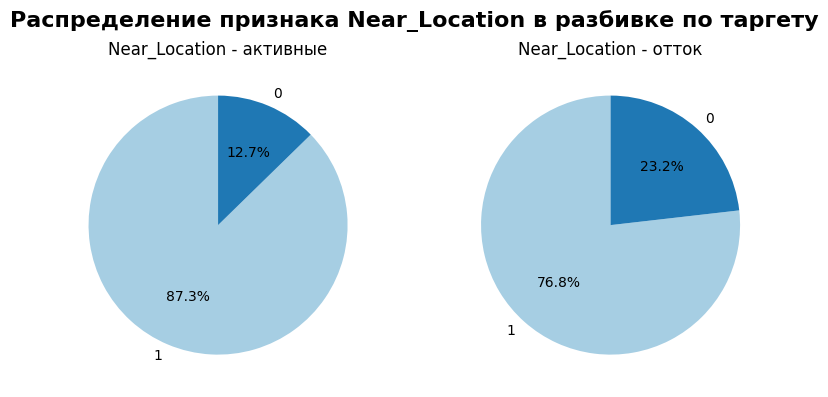

In [10]:
plot_churn_pie(df, 'Near_Location')

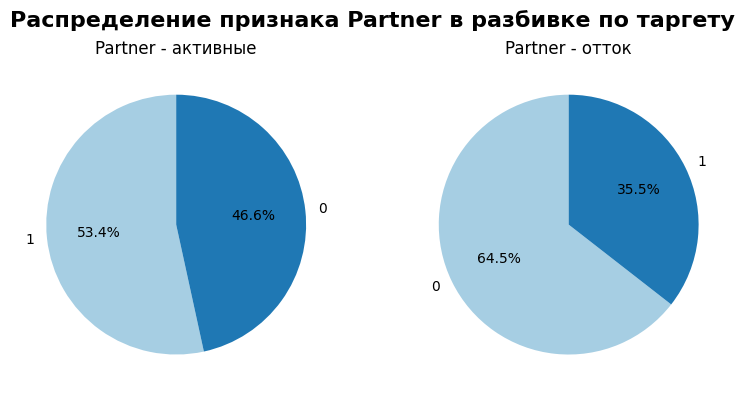

In [11]:
plot_churn_pie(df, 'Partner')

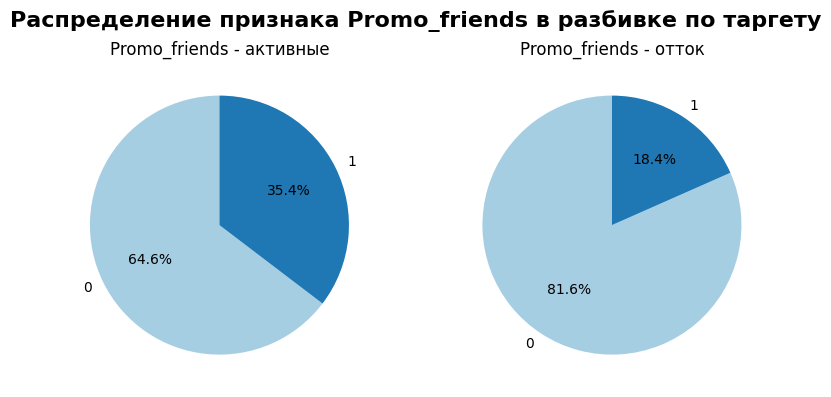

In [12]:
plot_churn_pie(df, 'Promo_friends')

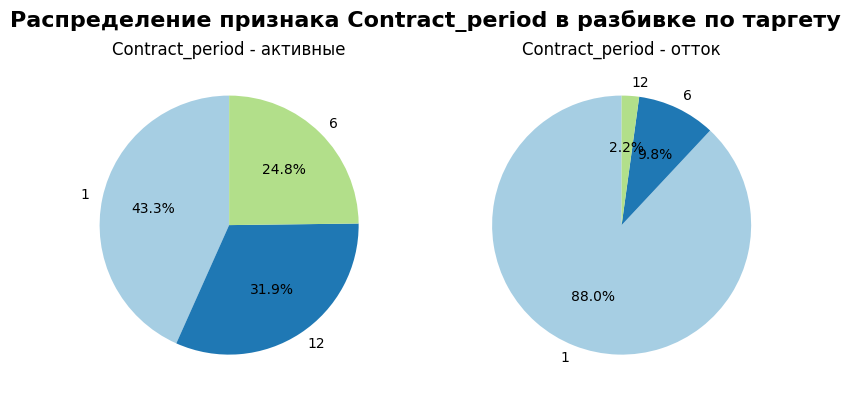

In [13]:
plot_churn_pie(df, 'Contract_period')

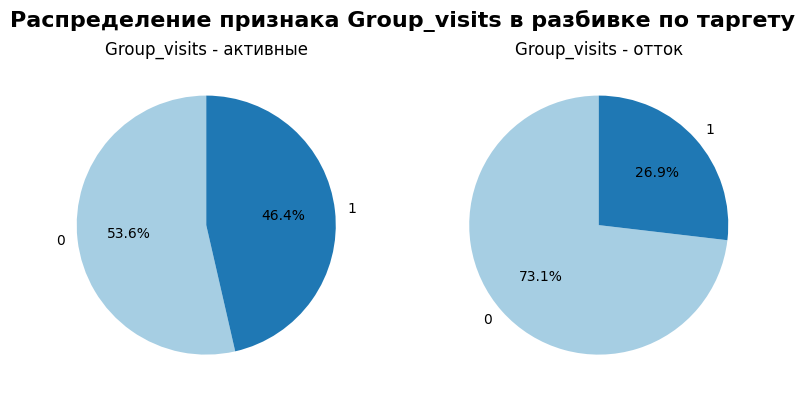

In [14]:
plot_churn_pie(df, 'Group_visits')

In [15]:
def plot_histogram(df, feature, title, xlabel):
    churn_0 = df[df['Churn'] == 0]
    churn_1 = df[df['Churn'] == 1]
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.histplot(data=churn_0, x=feature, alpha=0.5, ax=ax, label='активные')
    sns.histplot(data=churn_1, x=feature, ax=ax, color='red', label='отток')

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Частота')

    plt.legend()
    plt.show()

#### Интервальные переменные

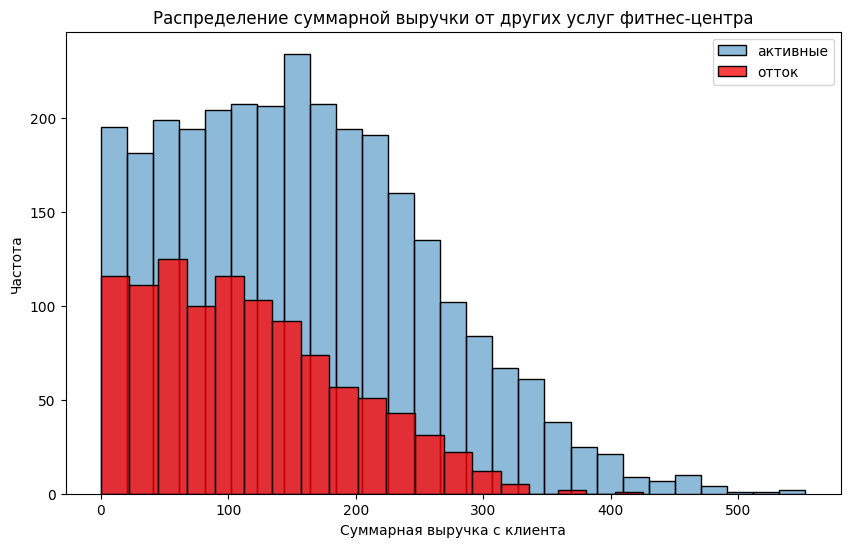

In [16]:
plot_histogram(df, 'Avg_additional_charges_total',
               title='Распределение суммарной выручки от других услуг фитнес-центра',
               xlabel='Cуммарная выручка c клиента')

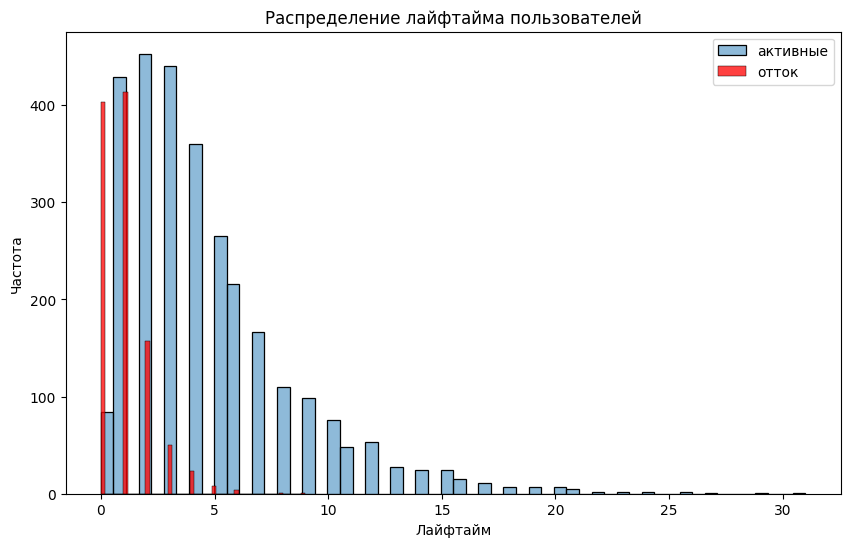

In [17]:
plot_histogram(df, 'Lifetime',
               title='Распределение лайфтайма пользователей',
               xlabel='Лайфтайм')

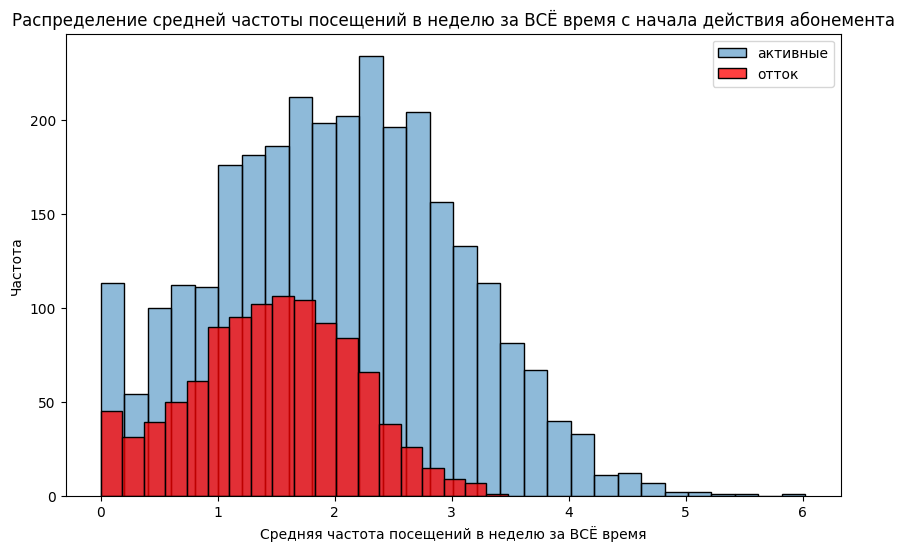

In [18]:
plot_histogram(df, 'Avg_class_frequency_total',
               title='Распределение средней частоты посещений в неделю за ВСЁ время с начала действия абонемента',
               xlabel='Средняя частота посещений в неделю за ВСЁ время')

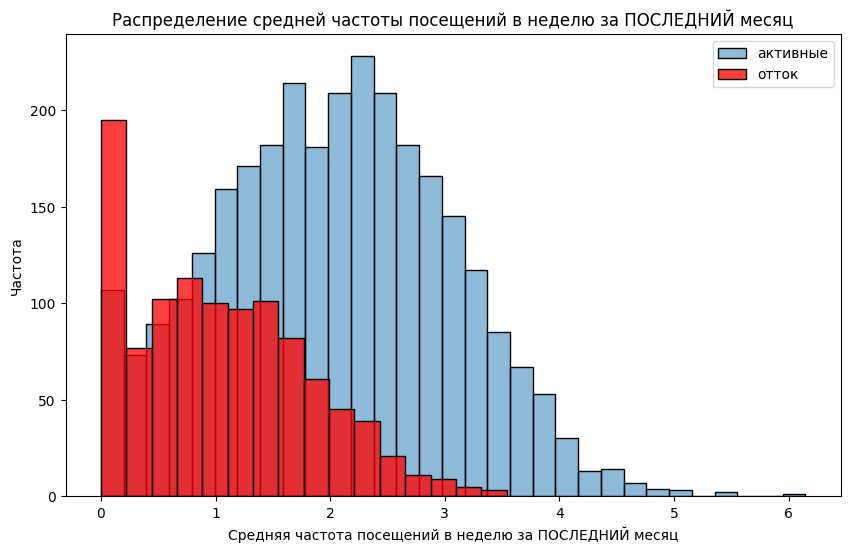

In [19]:
plot_histogram(df, 'Avg_class_frequency_current_month',
               title='Распределение средней частоты посещений в неделю за ПОСЛЕДНИЙ месяц',
               xlabel='Средняя частота посещений в неделю за ПОСЛЕДНИЙ месяц')

Очень много значений около нуля для клиентов в оттоке, для них посмотрим на квантили распределения средней частоты посещений в неделю за последний месяц

In [20]:
churn_0 = df[df['Churn'] == 0]
churn_1 = df[df['Churn'] == 1]
churn_1['Avg_class_frequency_current_month'].describe([0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 0.95, 0.99])

count    1061.000000
mean        1.044546
std         0.770237
min         0.000000
10%         0.000000
15%         0.088125
20%         0.298217
30%         0.558745
40%         0.771316
50%         0.979445
75%         1.588576
95%         2.374225
99%         3.058565
max         3.540271
Name: Avg_class_frequency_current_month, dtype: float64

Половина клиентов в оттоке в последнем месяце имели в среднем меньше 1 занятия в неделю

### Матрица корреляций

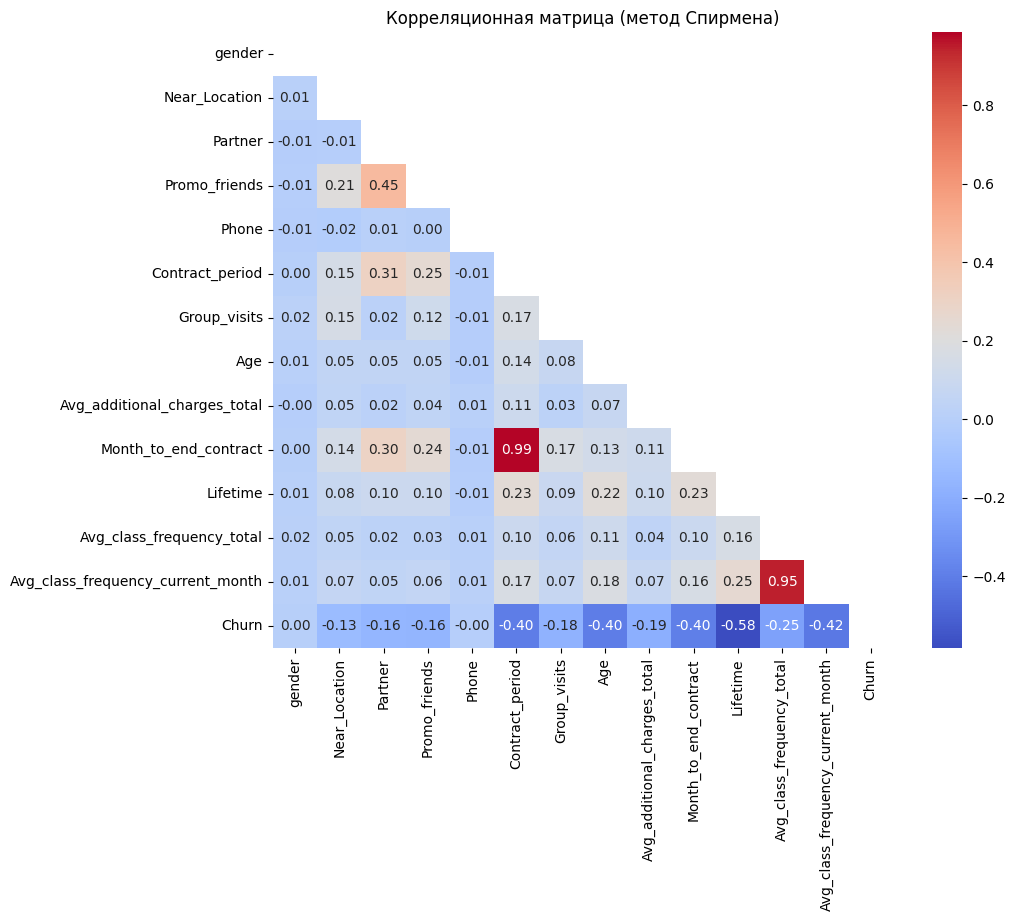

In [21]:
corr_matrix = df.corr(method='spearman')

# Создание треугольной матрицы для отображения половины корреляционной матрицы
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

plt.title('Корреляционная матрица (метод Спирмена)')

plt.show()

In [22]:
corr_matrix['Churn'].to_frame()

,Churn
gender,0.000708
Near_Location,-0.128098
Partner,-0.157986
Promo_friends,-0.162233
Phone,-0.001177
Contract_period,-0.402096
Group_visits,-0.175325
Age,-0.401664
Avg_additional_charges_total,-0.191432
Month_to_end_contract,-0.397513


Интерпретация коэффицентов корреляции (> 0.4 по модулю) признаков с таргетом:

**Contract_period:** Умеренная отрицательная корреляция (-0.4)
- Длительность текущего действующего абонемента существенно влияет на вероятность оттока: чем дольше абонемент, тем ниже вероятность оттока.

**Age:** Умеренная отрицательная корреляция (-0.4)
- Чем старше клиент, тем меньше вероятность его оттока.

**Lifetime:** Сильная отрицательная корреляция (-0.583)
- Время с момента первого обращения в фитнес-центр сильно связано с вероятностью оттока: чем дольше клиент посещает центр, тем меньше вероятность его ухода.

**Avg_class_frequency_current_month:** Умеренная отрицательная корреляция (-0.420)
- Частота посещений в неделю за последний месяц существенно влияет на вероятность оттока: чем чаще клиент посещает, тем меньше вероятность его ухода.

## Логистическая регрессия и случайный лес

In [24]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape[0] / X.shape[0], X_test.shape[0] / X.shape[0]

(0.8, 0.2)

In [25]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [26]:
log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train_sc, y_train)

random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(X_train_sc, y_train)

y_pred_log_reg = log_reg.predict(X_test_sc)
y_pred_random_forest = random_forest.predict(X_test_sc)

print("Лог регрессия:")
print("Accuracy:", '{:.3f}'.format(accuracy_score(y_test, y_pred_log_reg)))
print("Precision:", '{:.3f}'.format(precision_score(y_test, y_pred_log_reg)))
print("Recall:", '{:.3f}'.format(recall_score(y_test, y_pred_log_reg)))
print()
print("Random forrest:")
print("Accuracy:", '{:.3f}'.format(accuracy_score(y_test, y_pred_random_forest)))
print("Precision:", '{:.3f}'.format(precision_score(y_test, y_pred_random_forest)))
print("Recall:", '{:.3f}'.format(recall_score(y_test, y_pred_random_forest)))


Лог регрессия:
Accuracy: 0.922
Precision: 0.854
Recall: 0.828

Random forrest:
Accuracy: 0.915
Precision: 0.839
Recall: 0.813


Исходя из финансовой стратегии, фитнес-клубу может быть более важна метрика Precision или Recall, однако, для логистической регрессии и Precision, и Recall, и Accuracy выше, чем для случайного леса

## Кластеризация

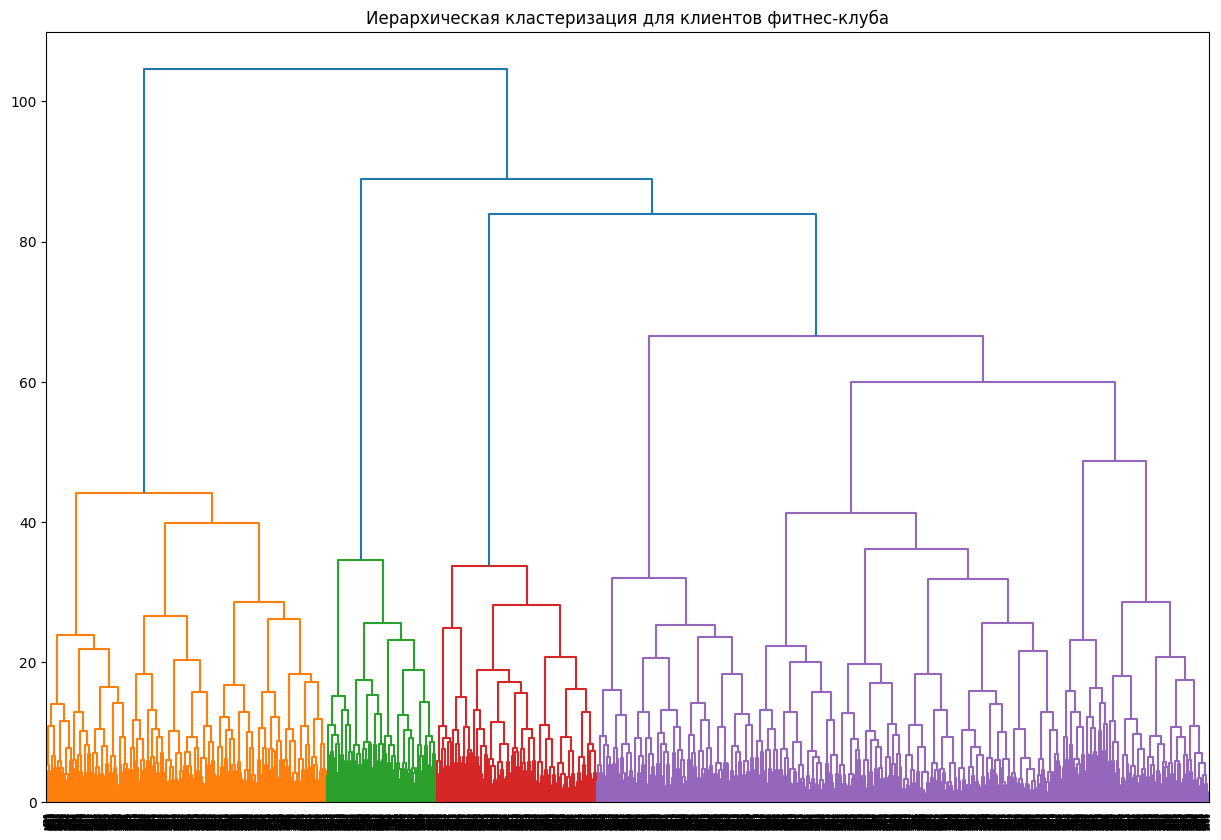

In [27]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для клиентов фитнес-клуба')
plt.xlabel('')
plt.show()

Судя по графику, имеется 4-5 кластеров клиентов

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

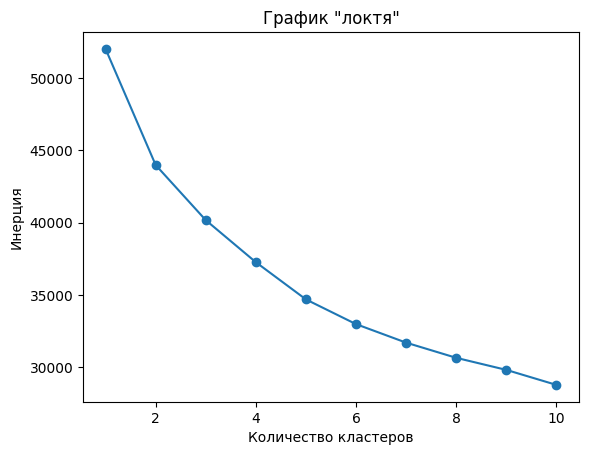

In [28]:
def broken_stick_plot(X, max_clusters=10):
    inertias = []
    for n_clusters in range(1, max_clusters + 1):
        km = KMeans(n_clusters=n_clusters, random_state=0)
        km.fit(X)
        inertias.append(km.inertia_)

    fig, ax = plt.subplots()
    ax.plot(range(1, max_clusters + 1), inertias, marker='o')
    ax.set_xlabel('Количество кластеров')
    ax.set_ylabel('Инерция')
    ax.set_title('График "локтя"')
    plt.show()

broken_stick_plot(X_sc)

В целом, 5 кластеров тоже неплохо описывают структуру данных. Построим модель KMeans для 5 кластеров

In [29]:
import itertools
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, random_state=0)

labels = km.fit_predict(X_sc)

df['cluster_km'] = labels

df.groupby('cluster_km').mean().T

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
Near_Location,0.959406,0.862338,0.000000,1.000000,0.976134
Partner,0.783168,0.470130,0.463366,0.350238,0.356802
Promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
Phone,1.000000,0.000000,1.000000,1.000000,0.998807
Contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
Group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
Age,29.982178,29.301299,28.477228,28.167987,30.125298
Avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
Month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Первичные выводы:

- 0 кластер - ходят в зал 2 раза в неделю, клиенты с годовыми контрактами, поэтому они не торопятся уходить
- 1 кластер - ходят в зал 1.7 раз в неделю, четверть таких клиентов уходит
- 2 кластер -  ходят в зал в среднем 1.5 раза в неделю, почти половина таких клиентов в оттоке
- 3 кластер - ходят в зал в среднем 1 раз в неделю, присоединились в среднем 2.5 месяца назад, контракт заканчивается меньше, чем через 2 месяца, половина таких клиентов в оттоке
- 4 кластер - самые надежные клиенты, они имеют высокий лайфтайм, которые ходят практически 3 раза в неделю


### Графики распределения признаков по кластерам

In [30]:
def plot_histogram_cluster(df, feature, title, xlabel):
    clusters = sorted(df['cluster_km'].unique())
    n_clusters = df['cluster_km'].nunique()

    rows = 2
    cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, cluster in enumerate(clusters):
        ax = axes[i]
        cluster_data = df[df['cluster_km'] == cluster]

        # churn_0 = cluster_data[cluster_data['Churn'] == 0]
        # churn_1 = cluster_data[cluster_data['Churn'] == 1]

        sns.histplot(data=cluster_data, x=feature, alpha=0.5, ax=ax) # label='активные',
        # sns.histplot(data=churn_1, x=feature, color='red', alpha=0.5, label='отток', ax=ax)

        ax.set_title(f'Кластер {cluster}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Частота')
        # ax.legend()
        ax.grid(True)
    plt.suptitle(f'{title} по кластерам', fontweight='bold', fontsize=20)

    # Удаляем пустые графики
    if n_clusters < rows * cols:
        for j in range(n_clusters, rows * cols):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


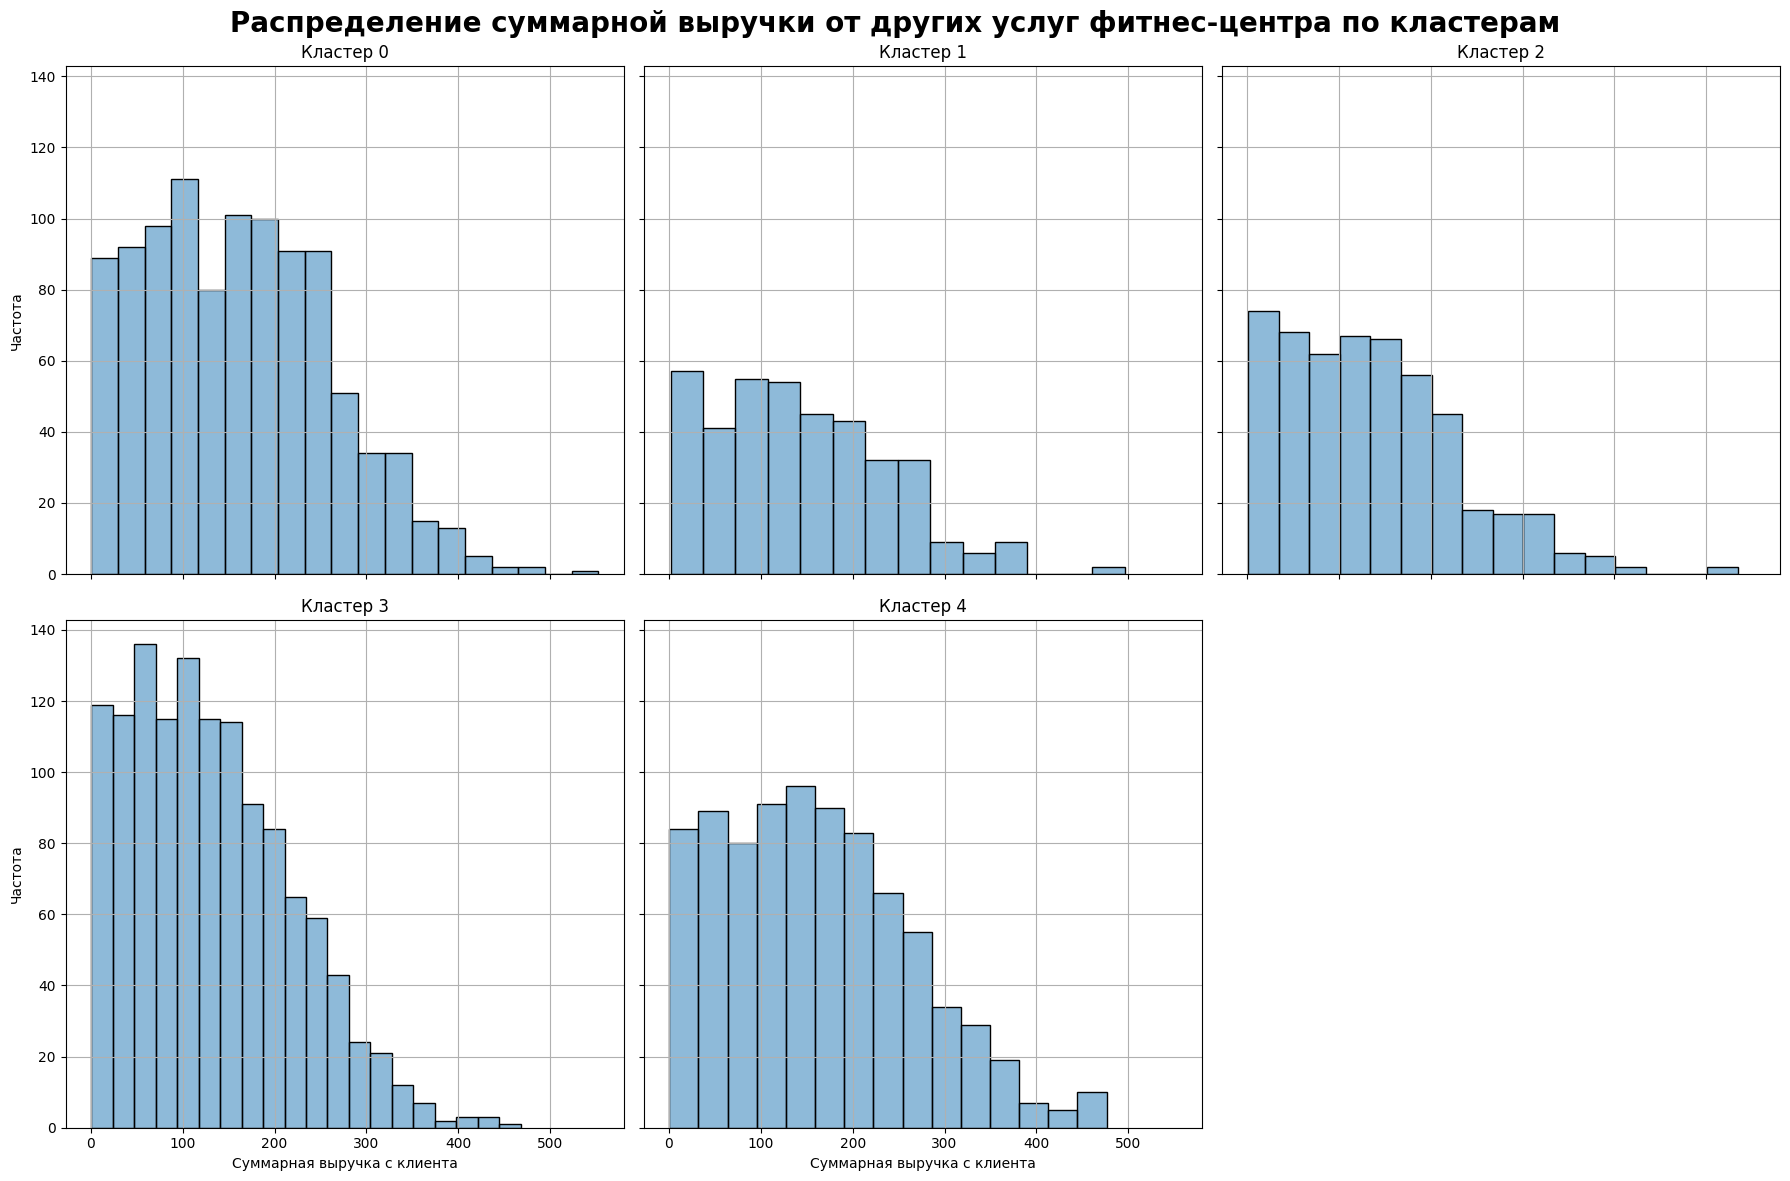

In [31]:
plot_histogram_cluster(df, 'Avg_additional_charges_total',
               title='Распределение суммарной выручки от других услуг фитнес-центра',
               xlabel='Cуммарная выручка c клиента')

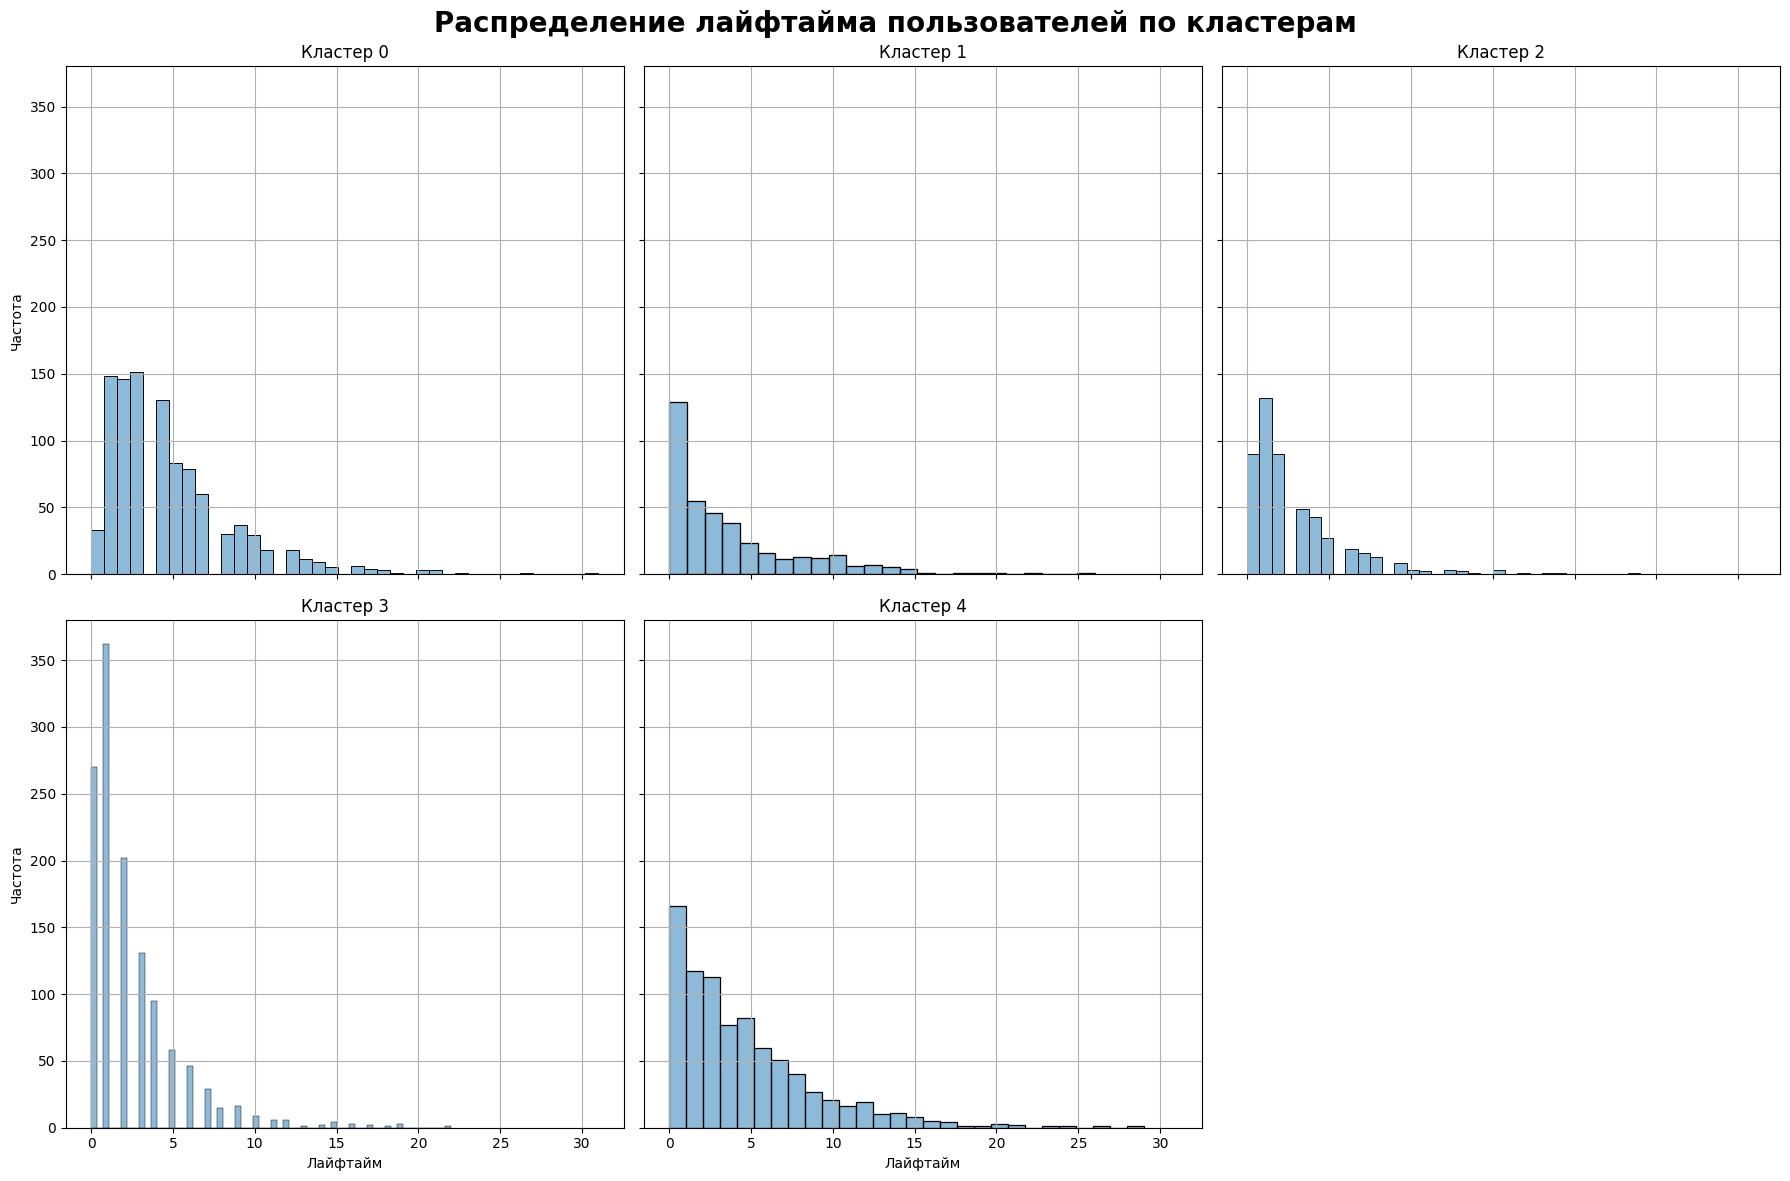

In [32]:
plot_histogram_cluster(df, 'Lifetime',
                        title='Распределение лайфтайма пользователей',
                        xlabel='Лайфтайм')

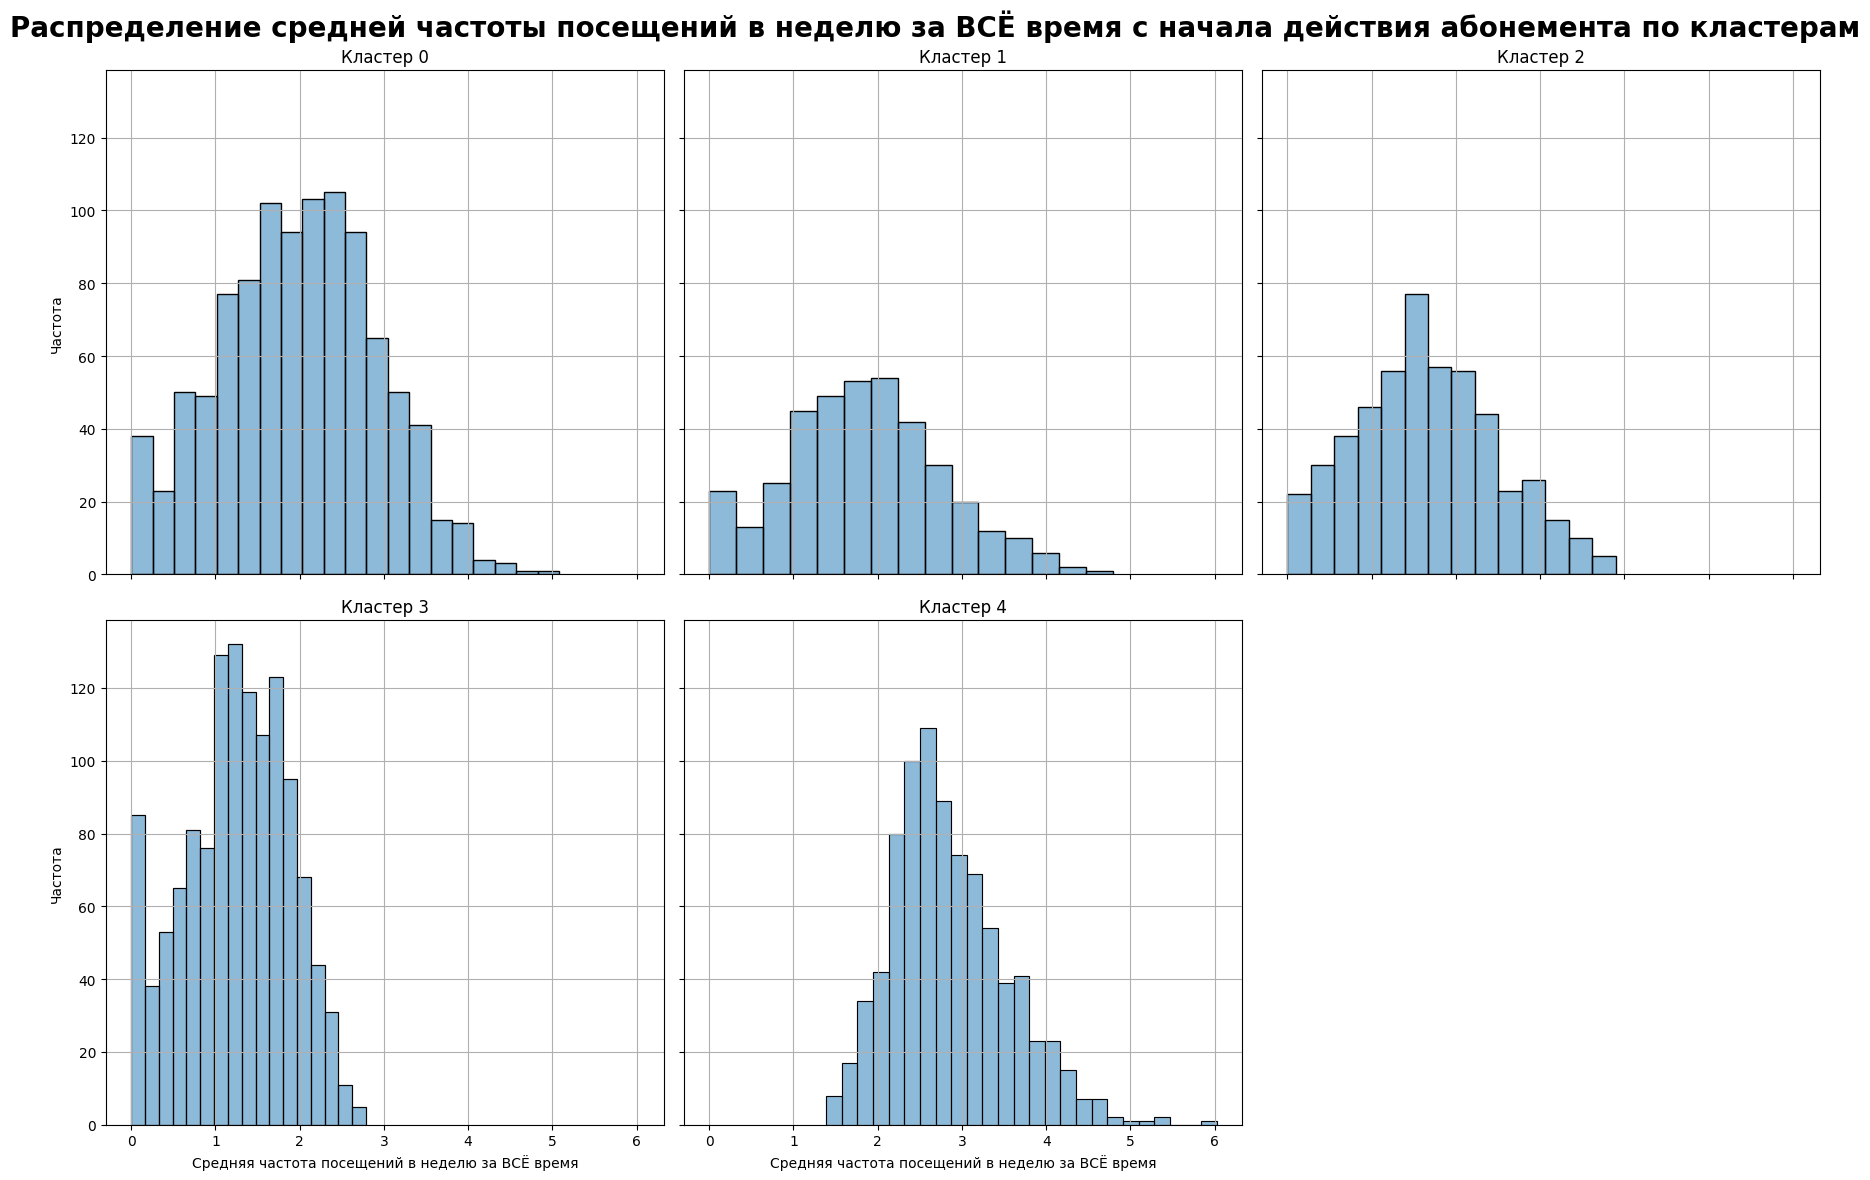

In [33]:
plot_histogram_cluster(df, 'Avg_class_frequency_total',
               title='Распределение средней частоты посещений в неделю за ВСЁ время с начала действия абонемента',
               xlabel='Средняя частота посещений в неделю за ВСЁ время')

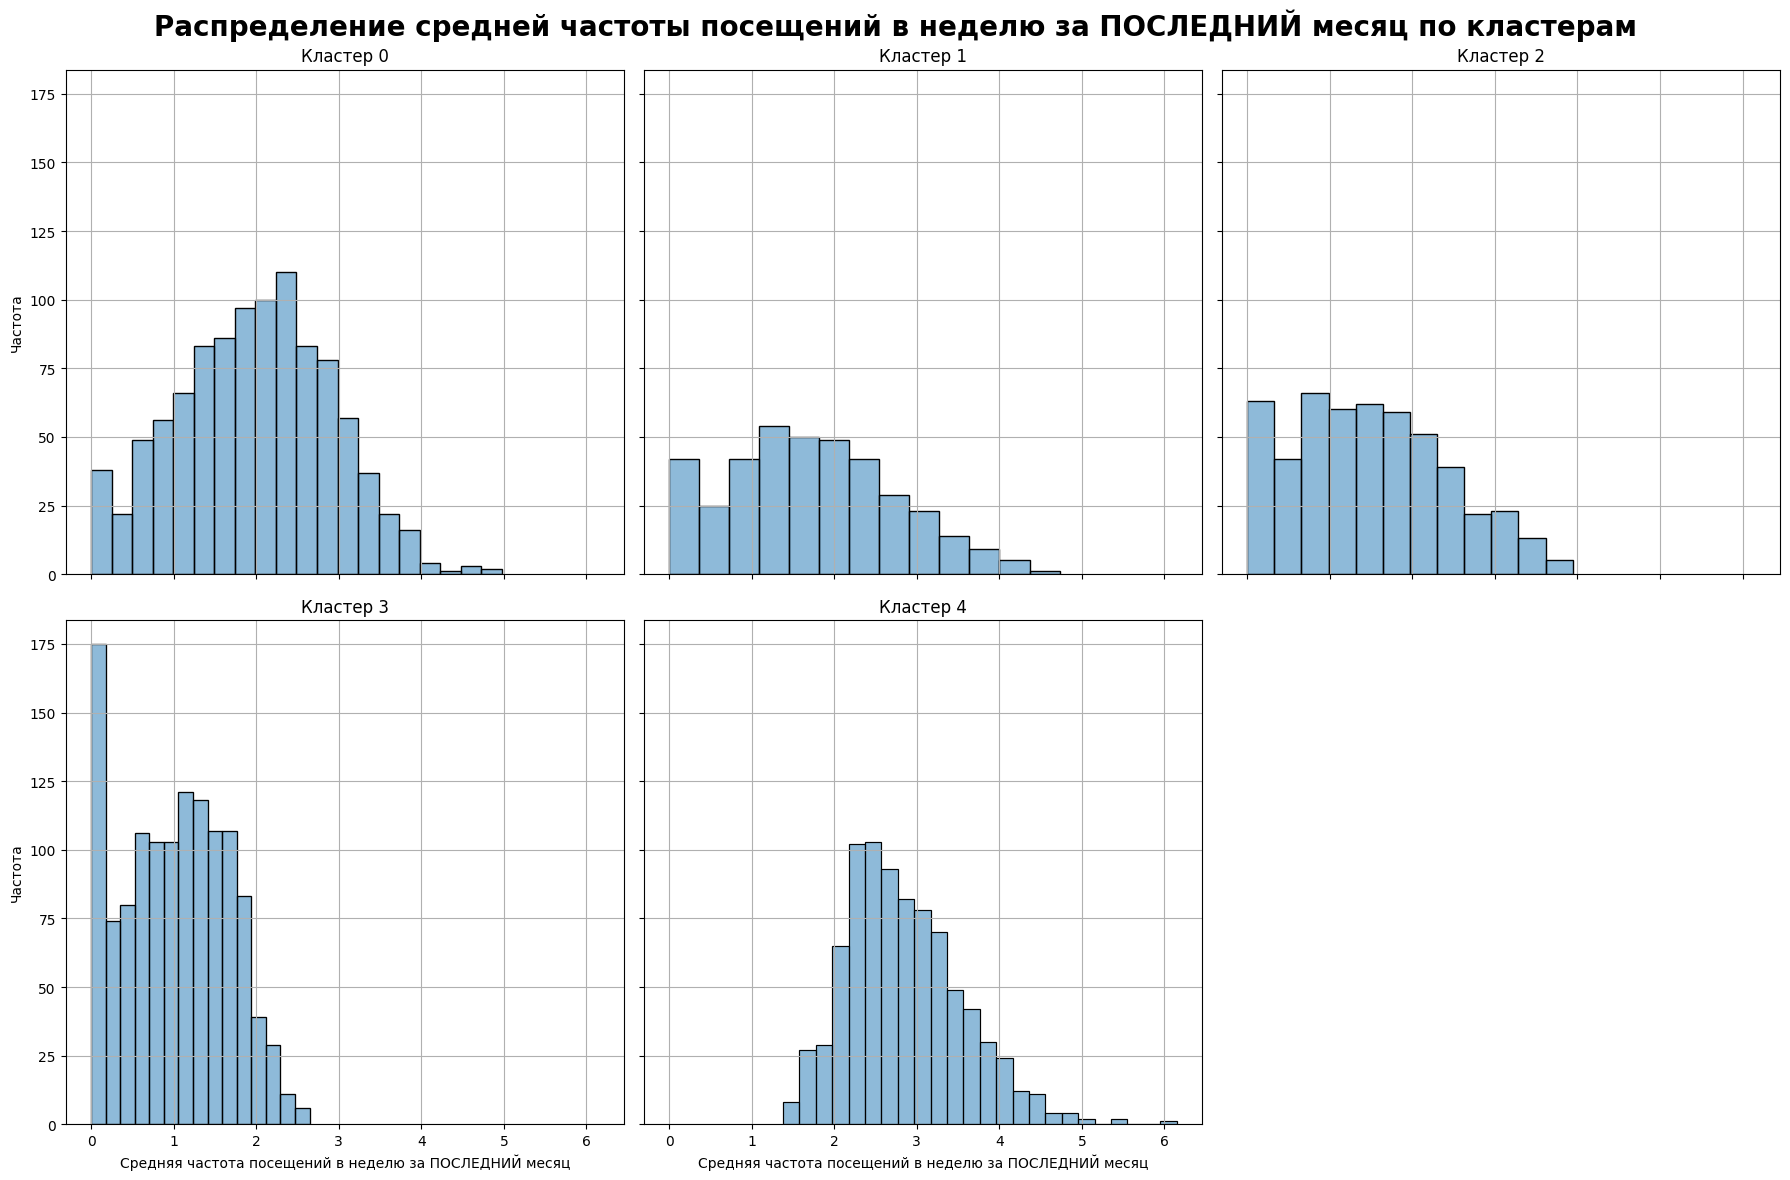

In [34]:
plot_histogram_cluster(df, 'Avg_class_frequency_current_month',
               title='Распределение средней частоты посещений в неделю за ПОСЛЕДНИЙ месяц',
               xlabel='Средняя частота посещений в неделю за ПОСЛЕДНИЙ месяц')

### Доля оттока по кластерам

In [35]:
df.groupby('cluster_km')['Churn'].mean().to_frame()

,Churn
cluster_km,
0,0.027723
1,0.267532
2,0.443564
3,0.514263
4,0.068019


- Самые надёжные клиенты - кластеры 0 и 4
- Относительно ненадёжные клиенты - кластер 1
- Самые ненадёжные клиенты - кластеры 2 и 3

# Выводы и рекомендации

### Основные выводы

1. **Кластеризация клиентов**:
   - **Кластер 0**: Низкий уровень оттока (2.77%), длительный контракт (10.89 месяцев), высокая частота посещений и дополнительных трат.
   - **Кластер 1**: Средний уровень оттока (26.75%), средний срок контракта (4.79 месяцев), посещения выше среднего, но ниже, чем в кластере 0.
   - **Кластер 2**: Высокий уровень оттока (44.36%), короткий контракт (2.35 месяцев), низкая частота посещений и дополнительных трат.
   - **Кластер 3**: Очень высокий уровень оттока (51.43%), самый короткий контракт (1.95 месяцев), низкая частота посещений.
   - **Кластер 4**: Низкий уровень оттока (6.80%), средний срок контракта (2.67 месяцев), высокая частота посещений и дополнительных трат.

2. **Факторы влияющие на отток**:
   - Клиенты, живущие или работающие рядом с фитнес-центром, имеют меньшую вероятность оттока (особенно заметно в кластерах 0 и 4).
   - Длительные контракты имеют меньшую вероятность оттока (кластеры 0 и 1).
   - Высокая частота посещений фитнес-клуба и участие в групповых занятиях снижают вероятность оттока.
   - Высокие дополнительные затраты (кафе, спорттовары и т.д.) также связаны с меньшим оттоком.
   - Участие в акциях типа "приведи друга" и наличие скидок для сотрудников компаний-партнеров снижают вероятность оттока (заметно в кластере 0).

### Рекомендации для стратегии взаимодействия с клиентами

1. **Персональные предложения**:
   - Например, предлагать гибкие условия продления контрактов для клиентов из групп с высоким риском оттока (кластеры 2 и 3). Возможно, предложить скидку при продлении контракта на более длительный срок или бесплатные дополнительные услуги.

2. **Групповые занятия**:
   -  Например, чаще организовать групповые занятия, чтобы повысить вовлеченность клиентов. Стоит рассмотреть включение бесплатных пробных занятий для клиентов, посещающих фитнес-клуб реже (особенно в кластерах 2 и 3), чтобы мотивировать их вернуться.

3. **Мониторинг посещаемости и оповещения клиентов**:
   - Например, внедрение системы оповещений и персональных предложений для клиентов, чья частота посещений снизилась.

4. **Развитие реферальных и партнерских программ**:
   - Например, стоит увеличить размер реферальных программ "приведи друга" и сотрудничества с компаниями-партнерами. Предложение бонусов за привлечение новых клиентов и скидок для сотрудников компаний-партнеров, чтобы удерживать клиентов в кластерах с низкой вероятностью оттока (кластеры 0 и 4).
